supply and demand analysis
calculate changes in oil reserves, including the SPR, weekly and compared to last year
determine if changes are in line with expectations
if not in line with expectations determine if it is do to higher demand, lower production, more exports or a combination

In [28]:
import pandas as pd
import USA_oil_data as oil
import prices
from FRED_oil_data import get_fred_data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [29]:
weekly_stocks = oil.weekly_stocks()
spr = oil.spr_reserves()

In [30]:
merged = pd.merge(weekly_stocks, spr, on='period')
merged.sort_index(inplace=True)

In [31]:
ticks = [x for x in range(0, 1400000, 200000)]

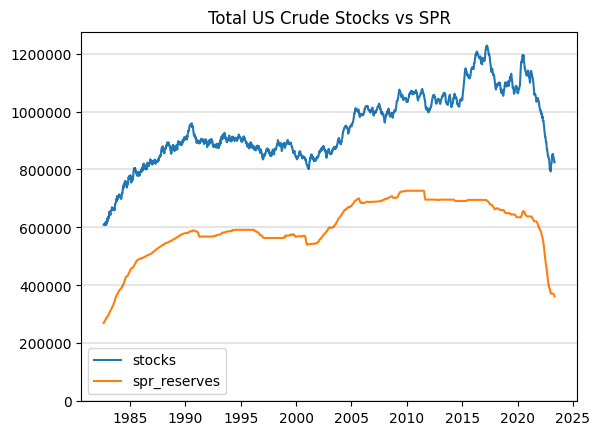

In [32]:
plt.plot(merged)

plt.yticks(ticks)
plt.ticklabel_format(axis='y', style='plain')
for t in ticks:
    plt.axhline(t, color='black', alpha=0.1)

plt.legend(merged.columns)
plt.title("Total US Crude Stocks vs SPR")
plt.show()

In [33]:
weekly_stocks = weekly_stocks.to_frame()

In [34]:
weekly_stocks['year'] = weekly_stocks.index.year
weekly_stocks['month'] = weekly_stocks.index.month
weekly_stocks = weekly_stocks[weekly_stocks['year'] > 2015]
monthly_average = weekly_stocks.groupby('month').mean()

In [35]:
grouped = weekly_stocks.groupby('year')

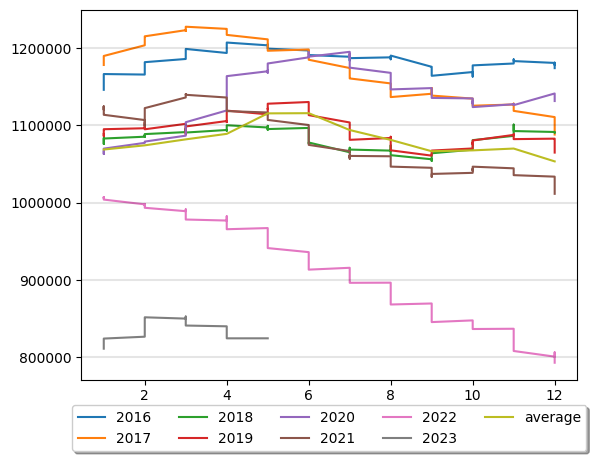

In [36]:
fig, ax = plt.subplots()

for name, group in grouped:
    ax.plot(group['month'], group['stocks'], label=name)
ax.plot(monthly_average.index, monthly_average['stocks'], label='average' )
plt.ticklabel_format(axis='y', style='plain')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
#add horizontal lines
ticks = [x for x in range(800000, 1300000, 100000)]
for t in ticks:
    plt.axhline(t, color='black', alpha=0.1)


plt.show()

In [37]:
weekly_stocks = oil.weekly_stocks()
weekly_stocks = weekly_stocks.to_frame()

weekly_stocks['year'] = weekly_stocks.index.year
weekly_stocks['month'] = weekly_stocks.index.month

weekly_stocks['diff'] = weekly_stocks['stocks'].diff(-1)
weekly_stocks = weekly_stocks[weekly_stocks['year'] >= 2018]

week_info = weekly_stocks.index.isocalendar()
week_number = week_info['week']

merged_df = pd.merge(week_number, weekly_stocks, left_index=True, right_index=True)

In [38]:
grouped = merged_df.groupby('year')

In [39]:
weeks = grouped['week'].unique()
years = len(grouped['year'].unique())
width = 0.8/years

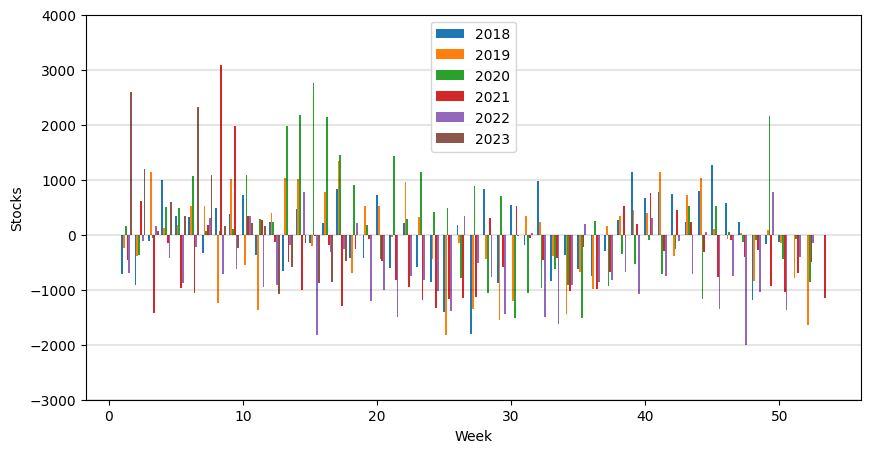

In [40]:
fig, ax = plt.subplots(figsize=(10,5))
i = 0
for name, group in grouped:
    data = group[group['week'] < 53]
    data = group['diff']/7
    positions = group['week']


    ax.bar(positions + i * width, data, width=width, label=name)
    i += 1

ticks = [x for x in range(-3000, 4000, 1000)]
for t in ticks:
    plt.axhline(t, color='black', alpha=0.1)

plt.ylim(-3000,4000)

ax.set_ylabel('Stocks')
ax.set_xlabel('Week')
ax.legend()

plt.show()

In [102]:
imports, exports = oil.imports_exports(only_crude=False)

In [103]:
imports_exports = pd.merge(imports, exports, on='period')

imports_exports['year'] = imports_exports.index.year
imports_exports = imports_exports[imports_exports['year'] > 2005]

In [104]:
imports_exports['net'] = imports_exports['imports'] - imports_exports['exports']

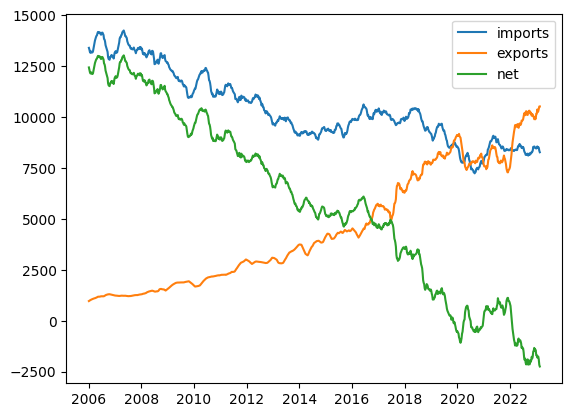

In [143]:
plt.plot(imports_exports[['imports', 'exports', 'net']].rolling(12).mean())
plt.legend(imports_exports[['imports', 'exports', 'net']])
#plt.axhline(0, color='black', alpha=0.1)

In [144]:
#supply data:

#production
production = oil.mbbl_production()

#reserves
reserves = oil.crude_oil_stocks()

#product supplied
product_supplied = oil.weekly_product_supplied()
monthly_product_supplied = product_supplied.resample('M').sum()
monthly_product_supplied.index = monthly_product_supplied.index - pd.offsets.MonthBegin(1)
monthly_product_supplied.rename("monthly_product_supplied", inplace=True)

#demand data:

#net exports (converted from MBBL/D to MBBL)
imp, exp = oil.imports_exports(only_crude=False)
imp_exp = pd.merge(imp, exp, on='period')
monthly_imp_exp = imp_exp.resample('M').sum()
monthly_imp_exp.index = monthly_imp_exp.index - pd.offsets.MonthBegin(1)
monthly_imp_exp['days_in_month'] = monthly_imp_exp.index.days_in_month
monthly_imp_exp['imports'] = monthly_imp_exp['imports'] * monthly_imp_exp['days_in_month']
monthly_imp_exp['exports'] = monthly_imp_exp['exports'] * monthly_imp_exp['days_in_month']
monthly_imp_exp = monthly_imp_exp[['imports', 'exports']]
monthly_imp_exp['net_imports'] = monthly_imp_exp['imports'] - monthly_imp_exp['exports']
monthly_imp_exp['net'] = monthly_imp_exp['imports'] - monthly_imp_exp['exports']
monthly_net_exports = monthly_imp_exp['net']
monthly_net_exports = monthly_net_exports.rename('net_imports_MBBL')





#sales (not updated since March 2022)
#gas_end_users = oil.gasoline_sales_end_user()
#gas_resale = oil.gasoline_sales_resale()


In [145]:
#merge all data into one dataframe
supply_demand = pd.merge(production, reserves, on='period')
supply_demand = pd.merge(supply_demand, monthly_product_supplied, on='period')
supply_demand = pd.merge(supply_demand, monthly_net_exports, on='period')


In [146]:
#changes = supply_demand.diff(12)
changes = supply_demand.pct_change(12)

In [147]:
changes = changes[changes.index > '2018-12-01']

<AxesSubplot:xlabel='period'>

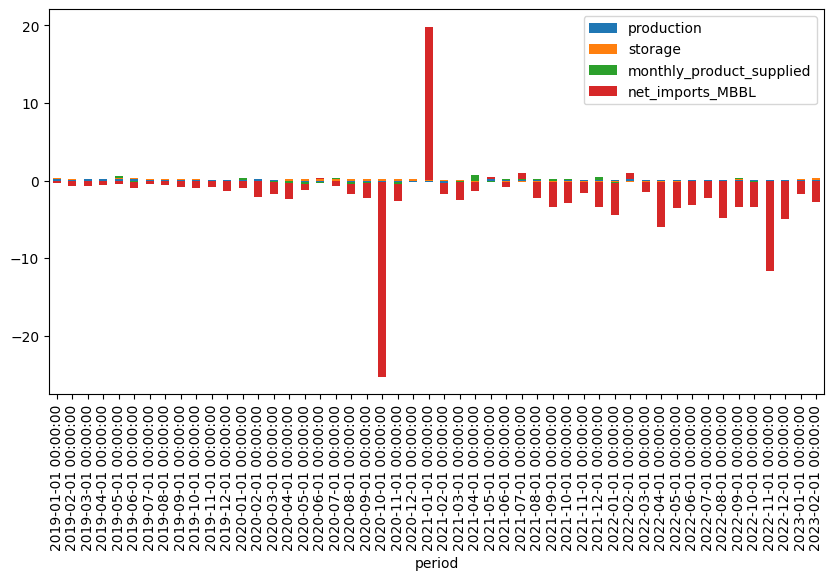

In [148]:
fig, ax = plt.subplots(figsize=(10,5))
changes.plot(kind='bar', stacked=True, ax=ax)
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

In [142]:
supply_demand

,production,storage,monthly_product_supplied,net_imports_MBBL
period,,,,
2007-05-01,161547,228113,29292,1638257
2007-06-01,152255,228573,104253,1944930
2007-07-01,156176,215062,83983,1580132
2007-08-01,154061,200939,106217,1909321
2007-09-01,147060,188447,81832,1446720
...,...,...,...,...
2022-10-01,384923,348820,81104,-251472
2022-11-01,371377,329958,81949,-246750
2022-12-01,376605,339058,101521,-309938


In [24]:
monthly_product_supplied

period
2007-05-01     29292
2007-06-01    104253
2007-07-01     83983
2007-08-01    106217
2007-09-01     81832
               ...  
2023-01-01     77494
2023-02-01     80469
2023-03-01     99265
2023-04-01     78384
2023-05-01     20163
Name: monthly_product_supplied, Length: 193, dtype: int64

In [130]:
imp, exp = oil.imports_exports(only_crude=False)
imp_exp = pd.merge(imp, exp, on='period')
monthly_imp_exp = imp_exp.resample('M').sum()
monthly_imp_exp.index = monthly_imp_exp.index - pd.offsets.MonthBegin(1)
monthly_imp_exp['days_in_month'] = monthly_imp_exp.index.days_in_month
monthly_imp_exp['imports'] = monthly_imp_exp['imports'] * monthly_imp_exp['days_in_month']
monthly_imp_exp['exports'] = monthly_imp_exp['exports'] * monthly_imp_exp['days_in_month']
monthly_imp_exp = monthly_imp_exp[['imports', 'exports']]
monthly_imp_exp['net_imports'] = monthly_imp_exp['imports'] - monthly_imp_exp['exports']
monthly_imp_exp['net'] = monthly_imp_exp['imports'] - monthly_imp_exp['exports']
net_exports = monthly_imp_exp['net']
net_exports = net_exports.rename('net_exports_MBBL')

In [131]:
net_exports

period
1991-02-01     439964
1991-03-01     843789
1991-04-01     755640
1991-05-01    1094734
1991-06-01     866400
               ...   
2023-01-01    -124217
2023-02-01    -142968
2023-03-01    -414408
2023-04-01    -202170
2023-05-01     -50437
Name: net_exports_MBBL, Length: 388, dtype: int64

In [129]:
monthly_imp_exp

,imports,exports,net_imports,net
period,,,,
1991-02-01,550788,110824,439964,439964
1991-03-01,1017699,173910,843789,843789
1991-04-01,860160,104520,755640,755640
1991-05-01,1232994,138260,1094734,1094734
1991-06-01,993840,127440,866400,866400
...,...,...,...,...
2023-01-01,1075266,1199483,-124217,-124217
2023-02-01,979412,1122380,-142968,-142968
2023-03-01,1270039,1684447,-414408,-414408


In [94]:
exp

period
2023-05-05     9237
2023-04-28    10657
2023-04-21    10516
2023-04-14    11084
2023-04-07     8671
              ...  
1991-03-08     1025
1991-03-01     1510
1991-02-22     1510
1991-02-15     1224
1991-02-08     1224
Name: exports, Length: 1683, dtype: int64

In [95]:
imp-exp

period
2023-05-05   -1627
2023-04-28   -2309
2023-04-21   -1681
2023-04-14   -2546
2023-04-07    -203
              ... 
1991-03-08    6102
1991-03-01    4678
1991-02-22    4711
1991-02-15    5349
1991-02-08    5653
Length: 1683, dtype: int64